In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D, BatchNormalization, Permute
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import random
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
from evaluator import Evaluator

Using TensorFlow backend.
/home/wliant/tech/workspaces/sls/mtech-sls/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wliant/tech/workspaces/sls/mtech-sls/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wliant/tech/workspaces/sls/mtech-sls/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

## Utility

In [2]:
class DDPGProcessor(Processor):
    def process_action(self, actions):
        exp = np.exp(actions)
        scaled_action = exp / np.sum(exp)
        return np.random.choice([0,1], p=scaled_action)

class CustomDDPGAgent(DDPGAgent):
    def select_action(self, state):
        eps = 0.1
        if self.training and np.random.uniform() < eps:
            return [0.5, 0.5]
        else:
            return super(CustomDDPGAgent, self).select_action(state)
        


### Forex-v0 default

In [3]:
window_size=24
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 5000), window_size=window_size)

env = env_creator()
obs = env.reset()
env_shape=obs.shape
nb_actions = env.action_space.n

def simple_critic_actor():
    nb_actions = 2
    # Next, we build a very simple model.
    actor = Sequential()
    actor.add(Flatten(input_shape=(1,) + env_shape))
    actor.add(Dense(128))
    actor.add(Activation('relu'))
    actor.add(Dense(64))
    actor.add(Activation('relu'))
    actor.add(Dense(nb_actions))
    actor.add(Activation('softmax'))
    # print(actor.summary())

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(64, activation='linear')(action_input)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([a1, flattened_observation])
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return actor, critic, action_input

#criticModel()[0].summary()
def agent_creator():
    actor, critic, action_input = simple_critic_actor()
    memory = SequentialMemory(limit=256, window_length=1)
    processor = DDPGProcessor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=2, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=random_process,processor=processor, gamma=.5, target_model_update=0.001)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent

Instructions for updating:
Colocations handled automatically by placer.
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
148/989 [===>..........................] - ETA: 0s - reward: -1.4439 - cumulative_reward: -99.0899WARNING:tensorflow:From /home/wliant/tech/workspaces/sls/mtech-sls/env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
989/989 [==============================] - 5s 5ms/step - reward: -11.1696 - cumulative_reward: -205.9923
train 1 completed. took 6.498 seconds, total_reward: -662.800000000048 total_profit: 0.6903566857161566
min reward: -178.6000000000021, max reward: 120.60000000000181, mean_reward: -0.13392604566580077


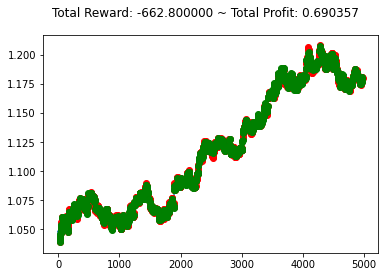

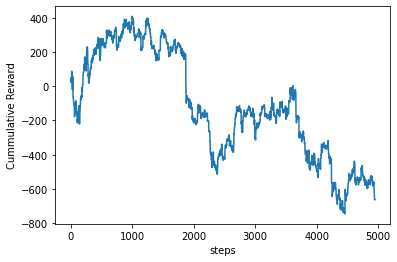

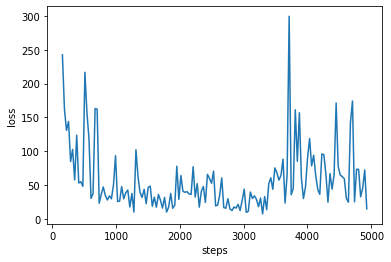

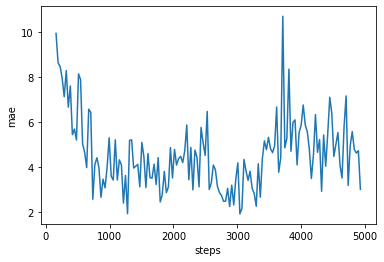

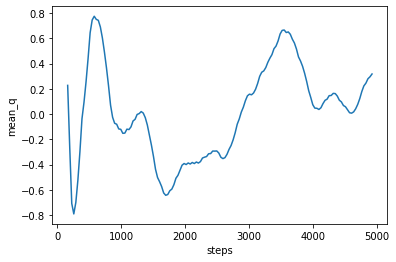

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 6s 6ms/step - reward: 26.6934 - cumulative_reward: 551.6281
train 2 completed. took 14.758 seconds, total_reward: 488.3999999999489 total_profit: 0.7274461890871085
min reward: -154.50000000000185, max reward: 122.70000000000225, mean_reward: 0.09868660335420264


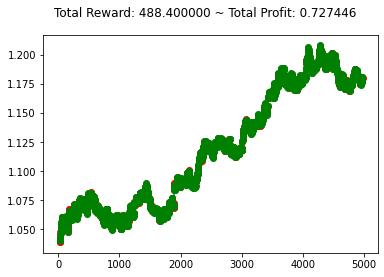

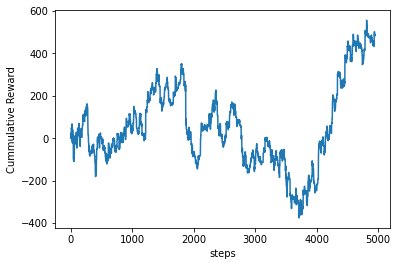

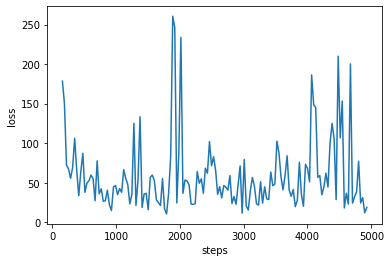

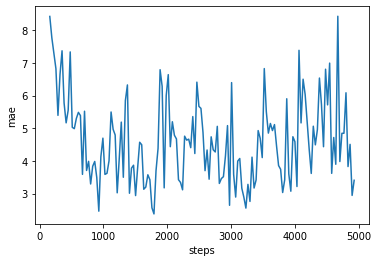

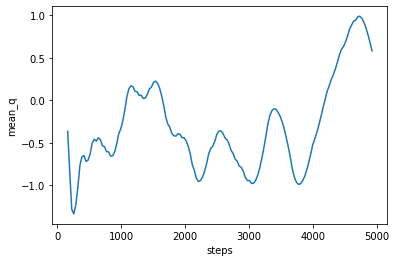

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 7s 7ms/step - reward: 30.2313 - cumulative_reward: 485.3126
train 3 completed. took 24.886 seconds, total_reward: -67.9999999999677 total_profit: 0.7125387360117955
min reward: -168.70000000000164, max reward: 112.90000000000022, mean_reward: -0.013740149525150071


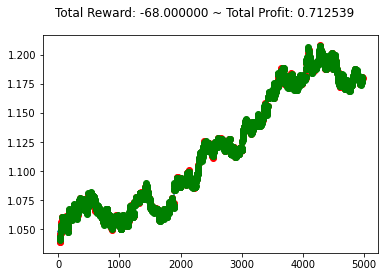

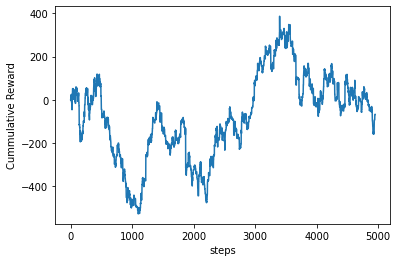

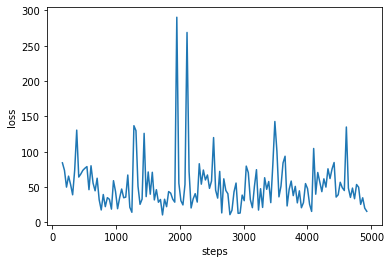

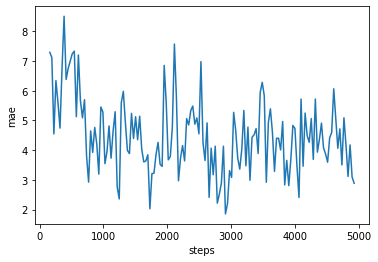

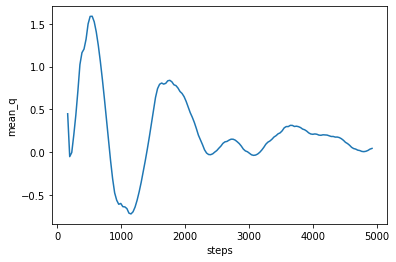

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 8s 8ms/step - reward: -34.8978 - cumulative_reward: -766.6856
train 4 completed. took 37.286 seconds, total_reward: -591.7000000000328 total_profit: 0.6904323497706468
min reward: -122.70000000000225, max reward: 168.70000000000164, mean_reward: -0.1195595069711119


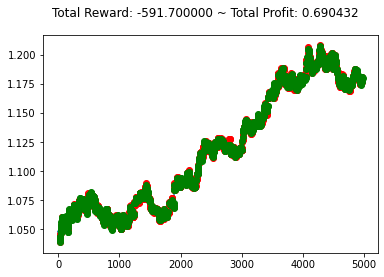

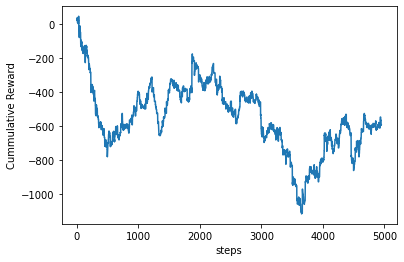

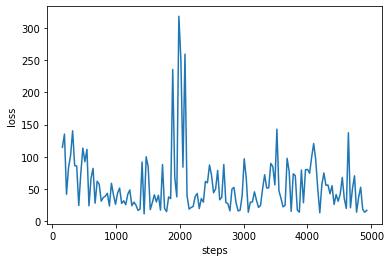

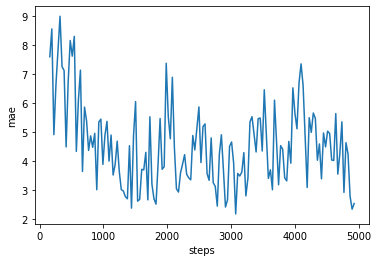

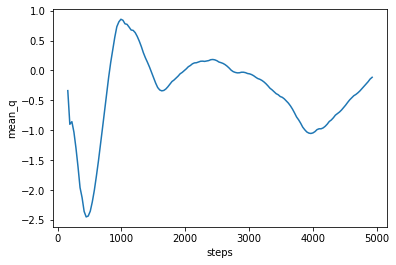

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 9s 9ms/step - reward: 22.2610 - cumulative_reward: -77.4107
train 5 completed. took 52.111 seconds, total_reward: -335.49999999998886 total_profit: 0.7093620940146087
min reward: -195.19999999999982, max reward: 129.89999999999836, mean_reward: -0.06779147302485125


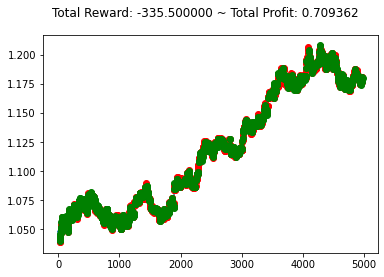

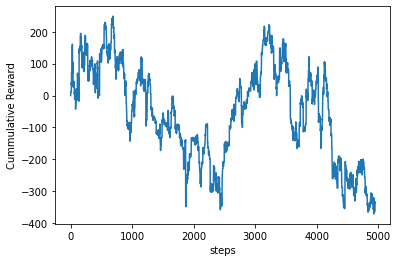

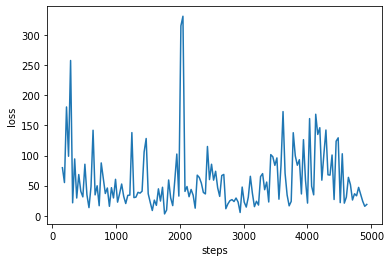

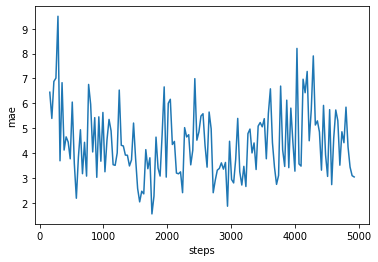

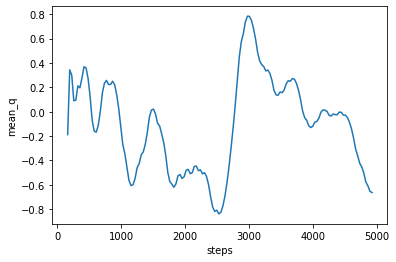

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 12s 12ms/step - reward: 36.5332 - cumulative_reward: 771.2280
train 6 completed. took 73.401 seconds, total_reward: 1121.5999999999322 total_profit: 0.7582483982345575
min reward: -104.59999999999914, max reward: 169.20000000000047, mean_reward: 0.22663164275609865


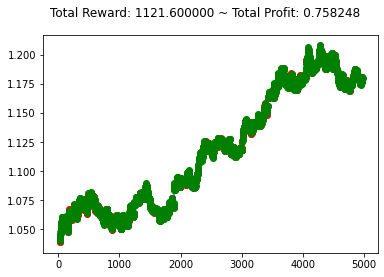

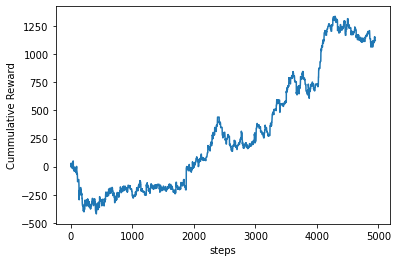

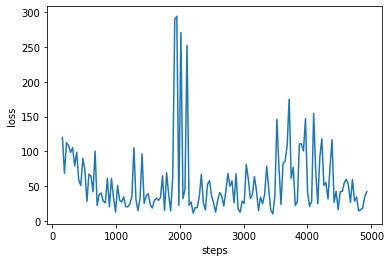

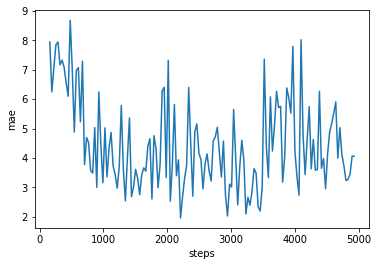

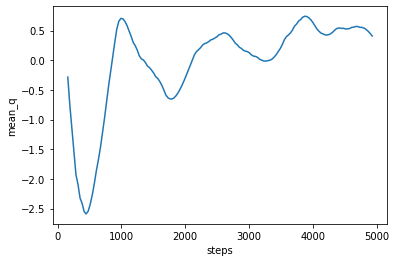

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 13s 13ms/step - reward: -36.4379 - cumulative_reward: -210.6368
train 7 completed. took 95.429 seconds, total_reward: -235.49999999984817 total_profit: 0.7043047015427905
min reward: -151.79999999999973, max reward: 104.80000000000045, mean_reward: -0.047585370781945475


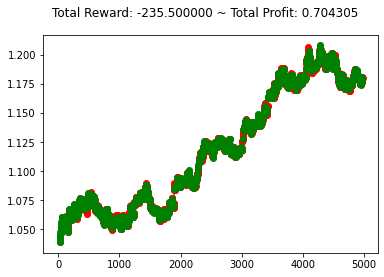

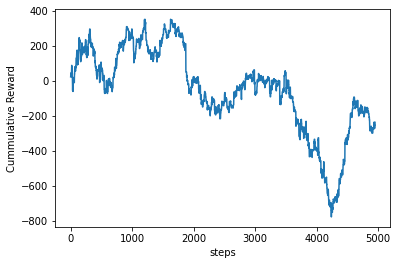

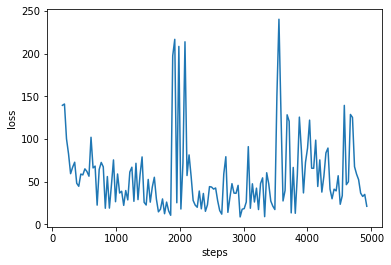

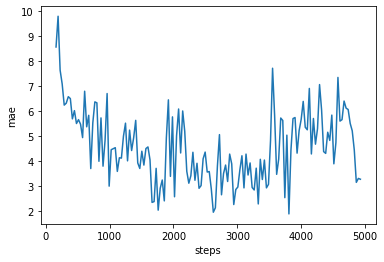

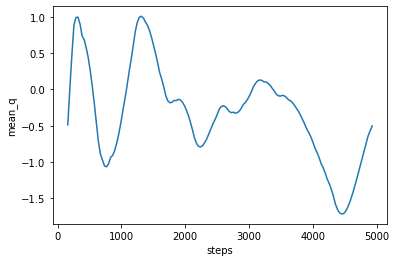

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 12s 12ms/step - reward: 21.7831 - cumulative_reward: -91.7212
train 8 completed. took 116.737 seconds, total_reward: -16.699999999997868 total_profit: 0.7239574103906711
min reward: -122.79999999999846, max reward: 178.6000000000021, mean_reward: -0.0033744190745600864


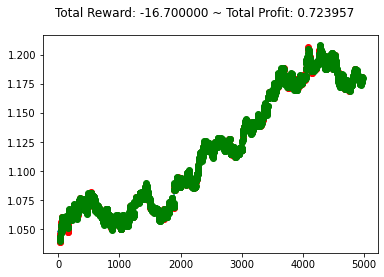

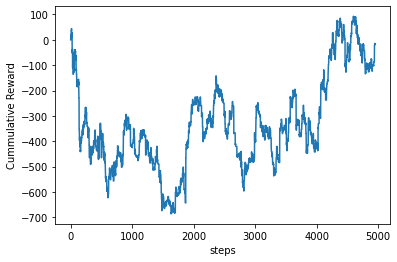

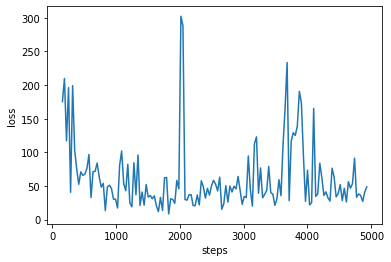

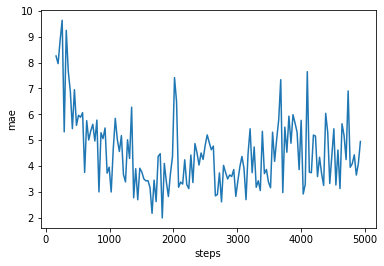

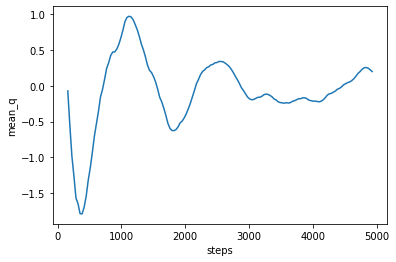

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 13s 13ms/step - reward: 4.3011 - cumulative_reward: -478.7362
train 9 completed. took 140.531 seconds, total_reward: -691.8000000000495 total_profit: 0.7072292048018216
min reward: -196.50000000000168, max reward: 128.59999999999872, mean_reward: -0.13978581531623552


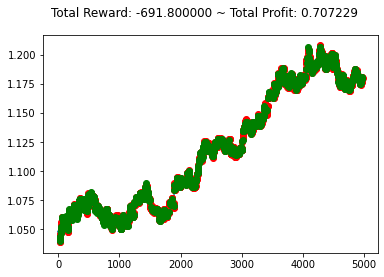

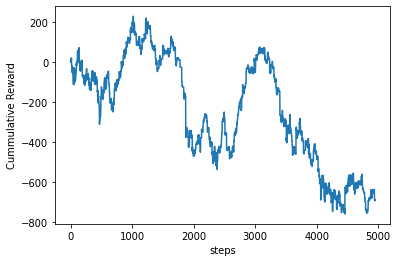

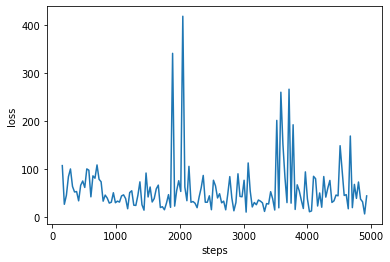

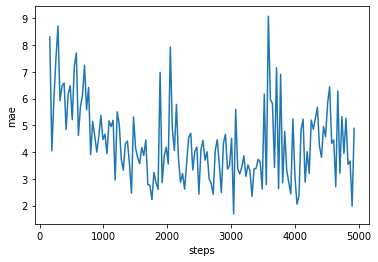

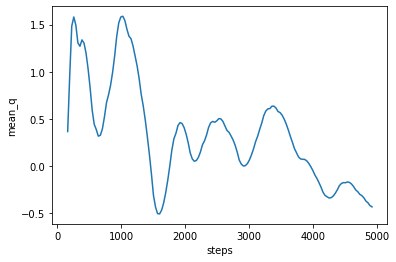

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 14s 15ms/step - reward: -1.5249 - cumulative_reward: -971.3881
train 10 completed. took 167.391 seconds, total_reward: -1509.3000000000452 total_profit: 0.6791600578058742
min reward: -137.40000000000086, max reward: 112.20000000000007, mean_reward: -0.30497070115175695


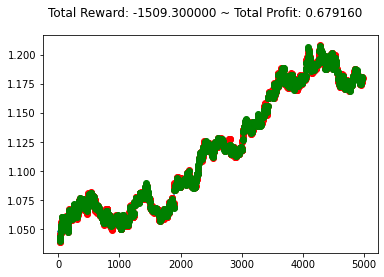

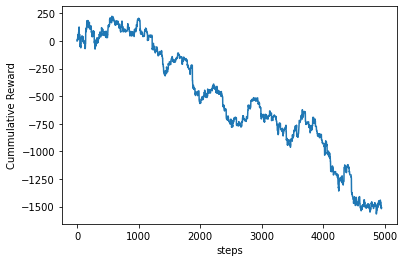

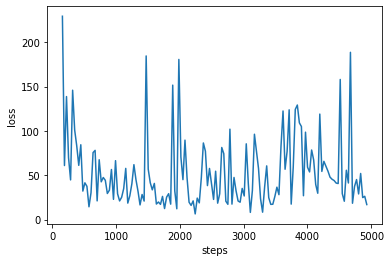

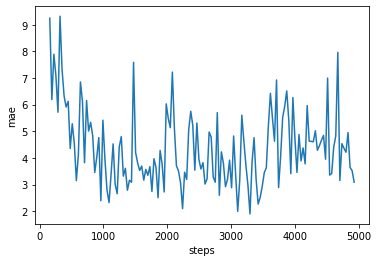

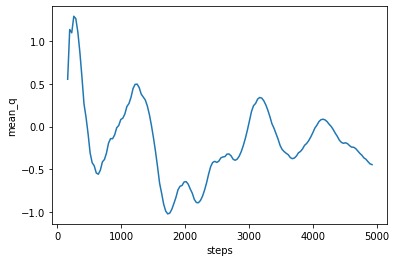

In [4]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="ddpg")
e.train(repeat=10)


average of total_reward across trainings: [-250.13]


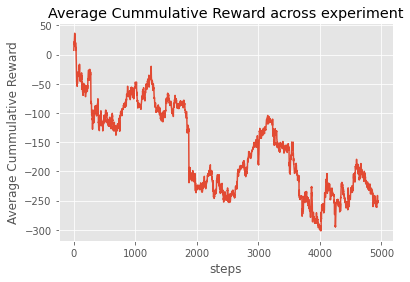

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
192/199 [===========================>..] - ETA: 0s - reward: -11.7070 - cumulative_reward: 29.9926Episode 1: reward: -7.300, steps: 999
test completed. total_reward: -7.299999999992288 total_profit: 0.9519481889203641
min reward: -82.00000000000207, max reward: 136.20000000000186, mean_reward: -0.0073073073072995876


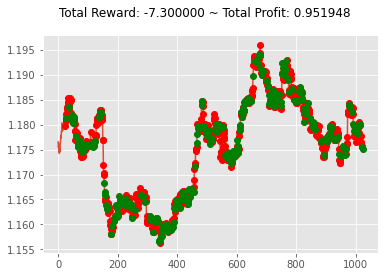

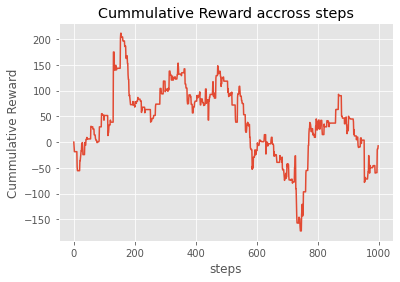

In [5]:
e.process_train_result()
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=window_size))

### Forex-v0 full feature

In [6]:
from custom_env import ForexV0FullFeature
def env_creator():
    return ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(50, 5000), window_size=window_size)
env = env_creator()
obs = env.reset()
env_shape=obs.shape
print(env_shape)
nb_actions = env.action_space.n

def simple_critic_actor():
    nb_actions = 2
    # Next, we build a very simple model.
    actor = Sequential()
    actor.add(Flatten(input_shape=(1,) + env_shape))
    actor.add(Dense(128))
    actor.add(Activation('relu'))
    actor.add(Dense(64))
    actor.add(Activation('relu'))
    actor.add(Dense(nb_actions))
    actor.add(Activation('softmax'))
    # print(actor.summary())

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(64, activation='linear')(action_input)
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    flattened_observation = Flatten()(observation_input)
    x = Concatenate()([a1, flattened_observation])
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(128)(x)
    x = Activation('relu')(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return actor, critic, action_input

#criticModel()[0].summary()
def agent_creator():
    actor, critic, action_input = simple_critic_actor()
    memory = SequentialMemory(limit=256, window_length=1)
    processor = DDPGProcessor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=2, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=random_process,processor=processor, gamma=.5, target_model_update=0.001)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent

(24, 15)


starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 18ms/step - reward: 21.4192 - cumulative_reward: -810.3060
train 1 completed. took 29.889 seconds, total_reward: -475.9000000000464 total_profit: 0.6825335301835648
min reward: -107.29999999999906, max reward: 168.70000000000164, mean_reward: -0.09616084057386268


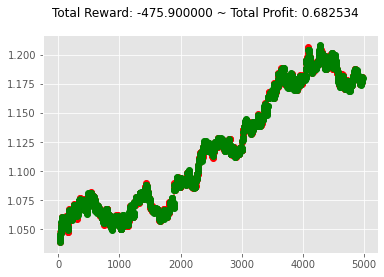

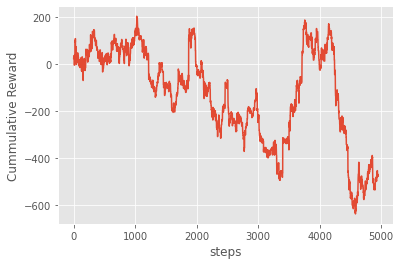

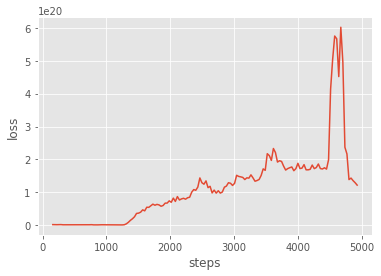

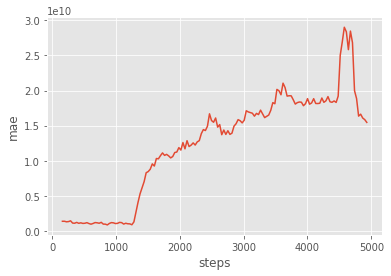

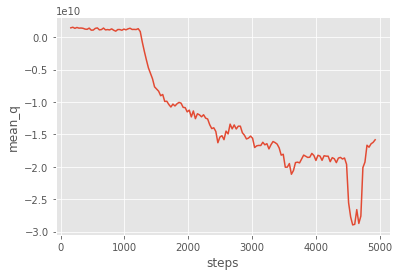

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 19s 19ms/step - reward: 9.7870 - cumulative_reward: -989.3771
train 2 completed. took 65.900 seconds, total_reward: -1992.500000000046 total_profit: 0.6157060188021735
min reward: -195.19999999999982, max reward: 76.80000000000132, mean_reward: -0.40260658718934045


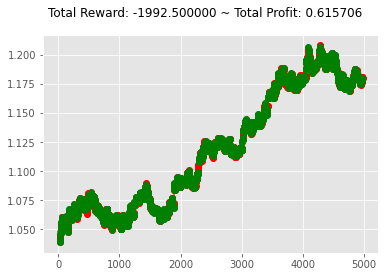

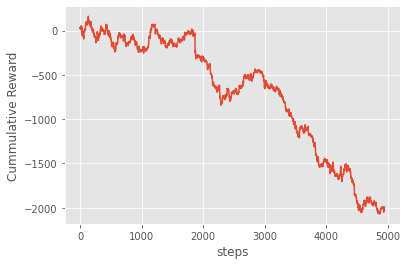

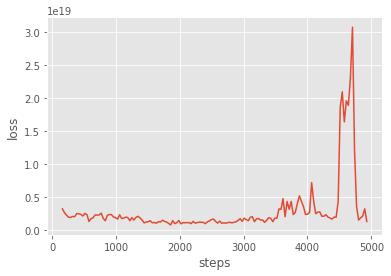

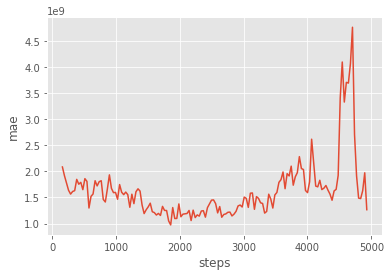

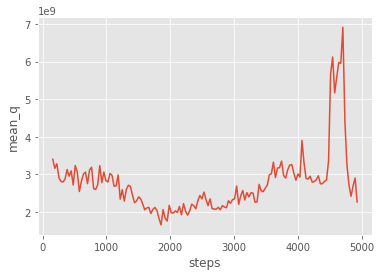

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 20s 20ms/step - reward: 2.6493 - cumulative_reward: -849.8302
train 3 completed. took 104.801 seconds, total_reward: -1039.9999999999327 total_profit: 0.6884826235655449
min reward: -114.70000000000091, max reward: 106.19999999999851, mean_reward: -0.21014346332591083


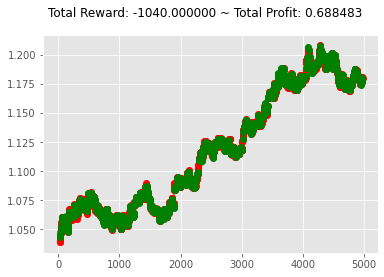

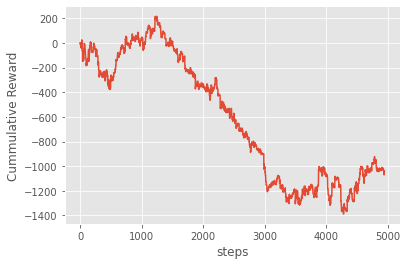

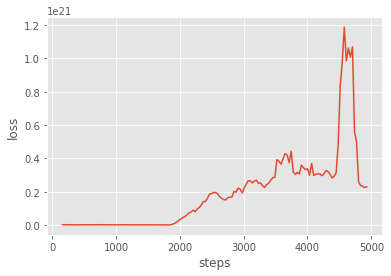

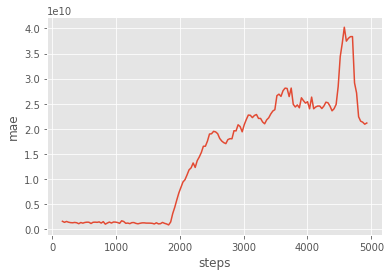

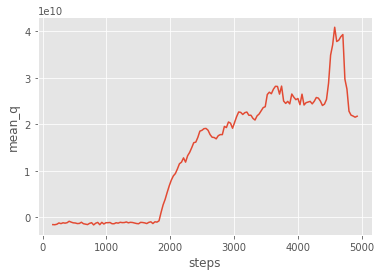

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 22s 22ms/step - reward: 0.1034 - cumulative_reward: -141.6719
train 4 completed. took 147.426 seconds, total_reward: 102.30000000002863 total_profit: 0.7246660982652524
min reward: -197.1999999999996, max reward: 114.60000000000025, mean_reward: 0.020670842594469312


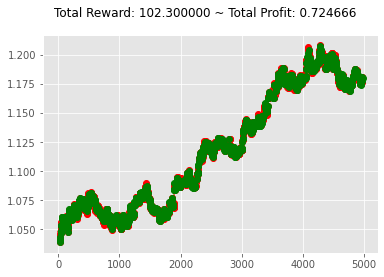

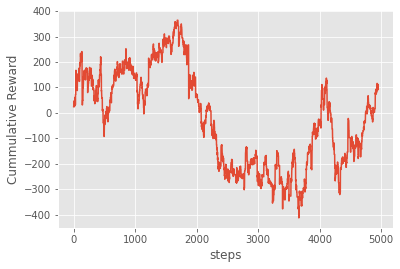

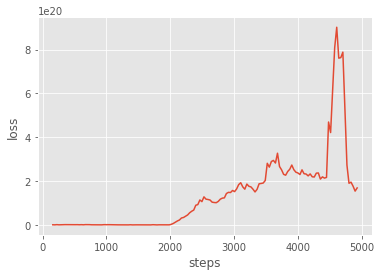

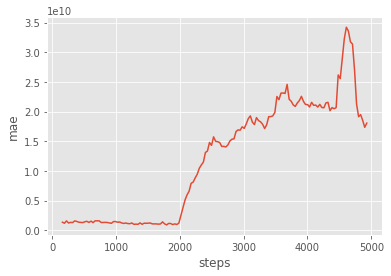

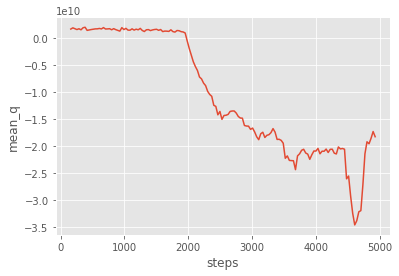

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 23s 24ms/step - reward: -0.8665 - cumulative_reward: -486.8037
train 5 completed. took 193.028 seconds, total_reward: -857.7000000000161 total_profit: 0.6915700560467194
min reward: -185.10000000000025, max reward: 85.79999999999811, mean_reward: -0.17330773893716228


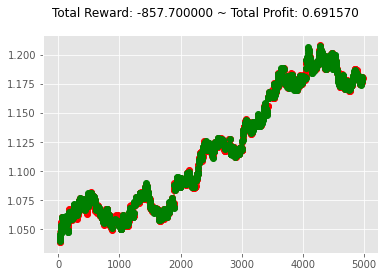

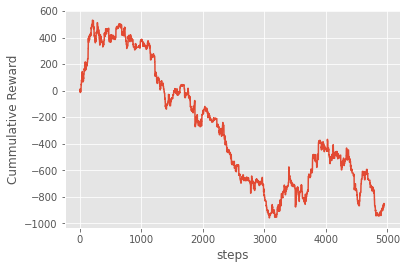

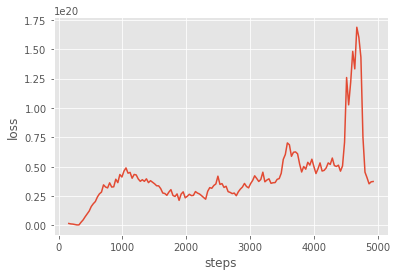

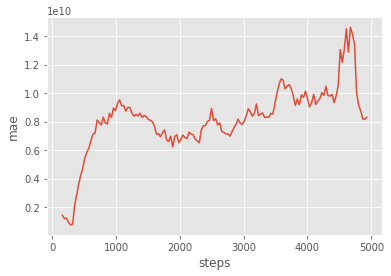

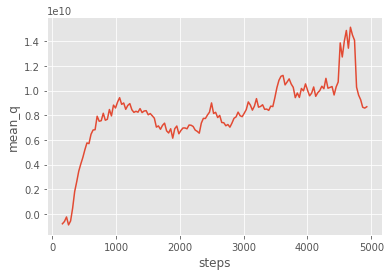

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 25s 25ms/step - reward: -11.3602 - cumulative_reward: 567.0939
train 6 completed. took 242.320 seconds, total_reward: 732.29999999996 total_profit: 0.7539041411609309
min reward: -107.29999999999906, max reward: 203.40000000000026, mean_reward: 0.14796928672458276


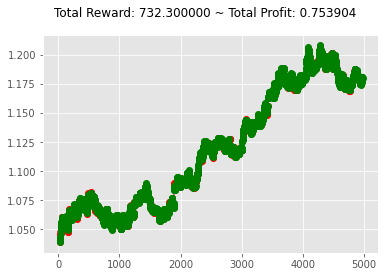

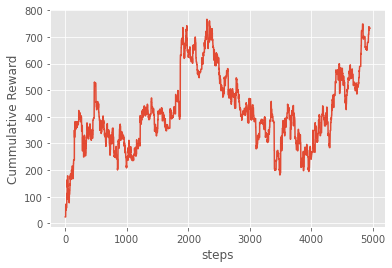

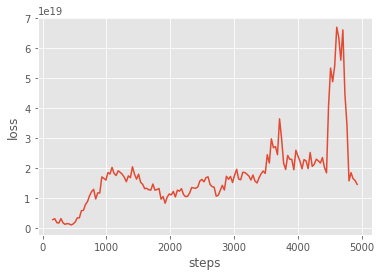

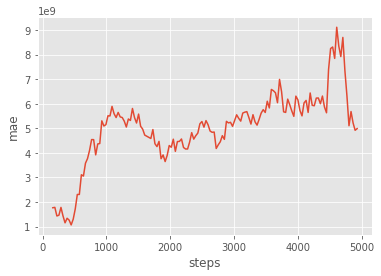

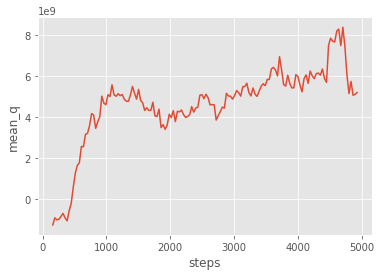

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 27s 27ms/step - reward: 13.5128 - cumulative_reward: 292.2070
train 7 completed. took 295.317 seconds, total_reward: 309.600000000073 total_profit: 0.7314589564458461
min reward: -102.99999999999976, max reward: 143.90000000000347, mean_reward: 0.06255809254396302


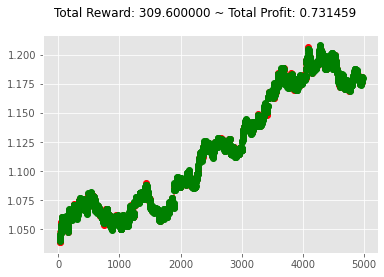

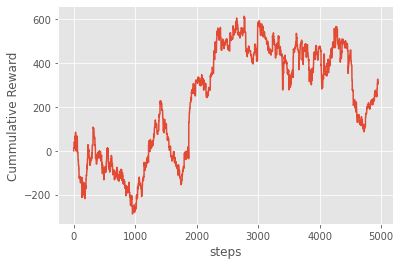

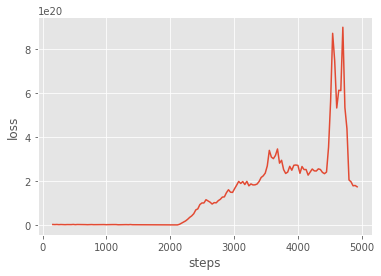

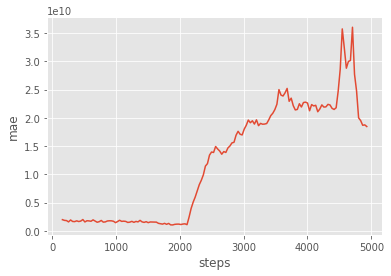

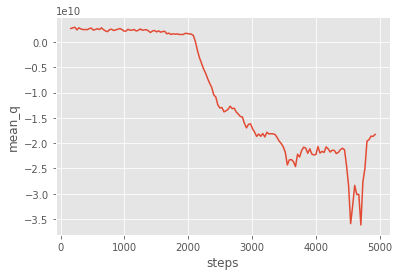

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 29s 29ms/step - reward: 22.9612 - cumulative_reward: 351.2742
train 8 completed. took 352.975 seconds, total_reward: 753.4000000001215 total_profit: 0.7419383376285215
min reward: -168.70000000000164, max reward: 97.69999999999834, mean_reward: 0.1522327742978625


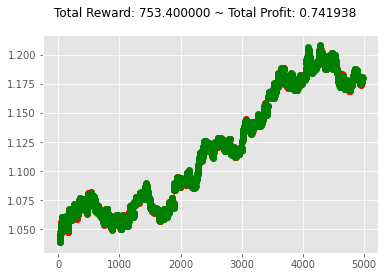

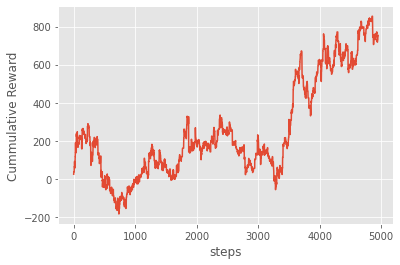

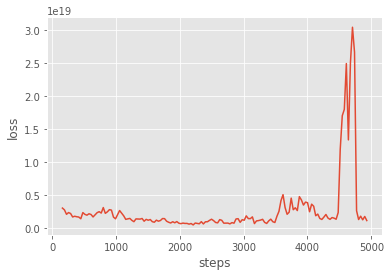

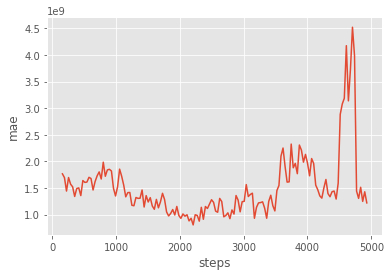

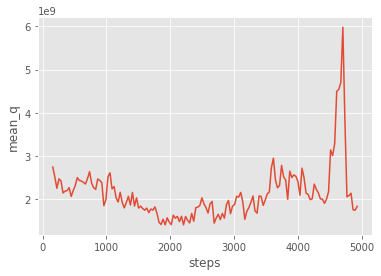

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 30s 31ms/step - reward: -9.7777 - cumulative_reward: 647.1311
train 9 completed. took 414.306 seconds, total_reward: 714.9000000001399 total_profit: 0.7327195109834516
min reward: -135.19999999999754, max reward: 143.90000000000347, mean_reward: 0.14445342493435845


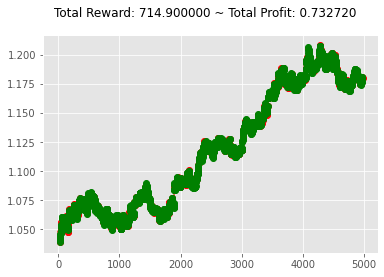

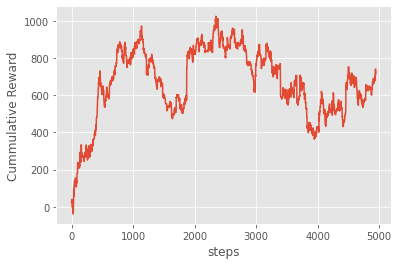

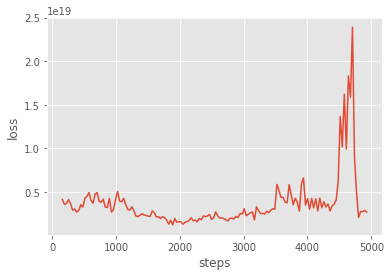

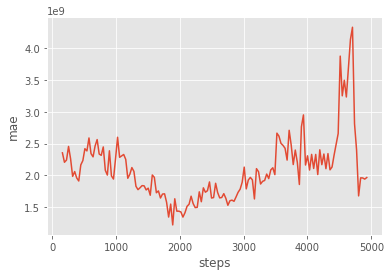

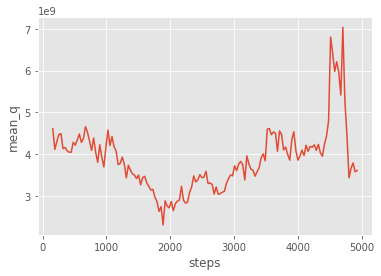

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 32s 32ms/step - reward: -17.8197 - cumulative_reward: 413.6267
train 10 completed. took 479.076 seconds, total_reward: 772.2999999998683 total_profit: 0.7319762290709299
min reward: -103.6999999999999, max reward: 179.60000000000198, mean_reward: 0.15605172762171515


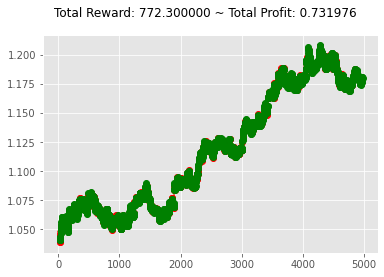

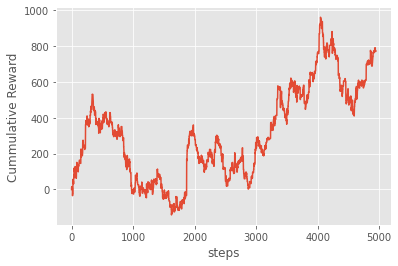

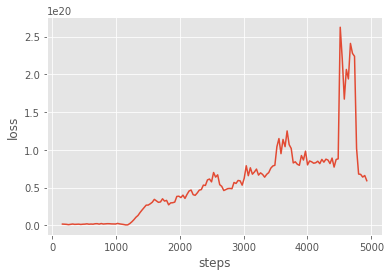

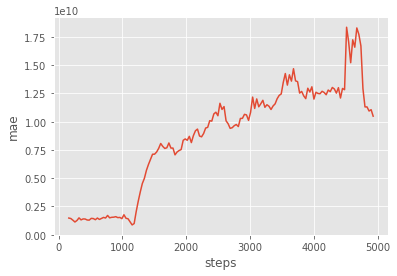

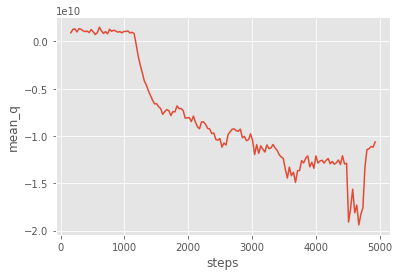

In [7]:
e = Evaluator(agent_creator, env_creator, name="ddpg-fullfeature")
e.train(repeat=10)

average of total_reward across trainings: [-98.13]


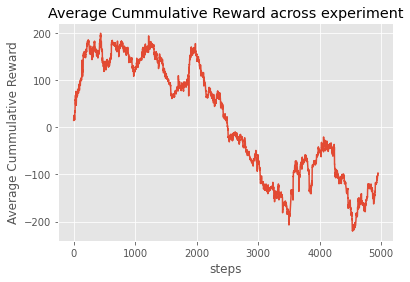

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
187/199 [===========================>..] - ETA: 0s - reward: -6.3866 - cumulative_reward: -66.6393Episode 1: reward: -136.500, steps: 999
test completed. total_reward: -136.5000000000526 total_profit: 0.941620048918625
min reward: -109.30000000000106, max reward: 65.69999999999965, mean_reward: -0.1366366366366893


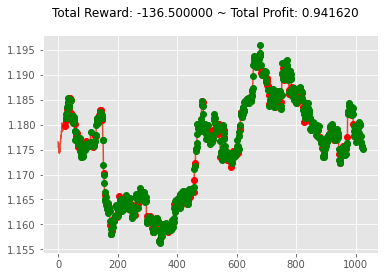

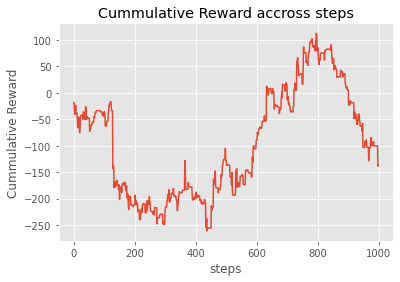

In [8]:
e.process_train_result()
e.test(ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(5000, 6000), window_size=window_size))

### Kaggle Dataset 

In [9]:
from data import EURUSD_HOUR
from custom_env import ExternalDataFullFeature

window_size=24
def env_creator():
    return ExternalDataFullFeature(df=EURUSD_HOUR, window_size=window_size, frame_bound=(50, 80000))


env = env_creator()
env_shape = env.reset().shape
print("max possible profit: {}".format(env.max_possible_profit()))
def critic_actor():
    observation_input = Input(shape=(1,) + env_shape, name='observation_input')
    obs = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs)
    obs = BatchNormalization()(obs)
    obs = Flatten()(obs)

    obs_1 = Dense(256, activation='relu')(obs)
    obs_1 = Dropout(0.2)(obs_1)
    obs_1 = Dense(64, activation='relu')(obs_1)
    obs_out = Dense(nb_actions, activation='softmax')(obs_1)
    actor = Model(inputs=[observation_input], outputs=obs_out)
    # print(actor.summary())

    obs_2 = Permute((2, 3, 1), input_shape=(1,) + env_shape)(observation_input)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(obs_2)
    obs_2 = BatchNormalization()(obs_2)
    obs_2 = Flatten()(obs_2)

    action_input = Input(shape=(nb_actions,), name='action_input')
    a1 = Dense(32, activation='linear')(action_input)

    x = Concatenate()([a1, obs])
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)
    x = Activation('linear')(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    # print(critic.summary())
    return actor, critic, action_input

def agent_creator():
    actor, critic, action_input = critic_actor()
    memory = SequentialMemory(limit=256, window_length=1)
    processor = DDPGProcessor()
    random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.05, mu=0.02, sigma=0.03)
    agent = DDPGAgent(nb_actions=2, actor=actor, critic=critic, critic_action_input=action_input,
                      memory=memory, nb_steps_warmup_critic=128, nb_steps_warmup_actor=128, batch_size=64, train_interval=32,
                      random_process=random_process,processor=processor, gamma=.5, target_model_update=0.001)
    agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])
    return agent


max possible profit: 2485856055592.9863


starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2247s 140ms/step - reward: 27.7452 - cumulative_reward: 1261.0923
train 1 completed. took 2286.932 seconds, total_reward: 2321.400000000153 total_profit: 0.026141125574982313
min reward: -467.0000000000019, max reward: 377.60000000000014, mean_reward: 0.029036010456668038


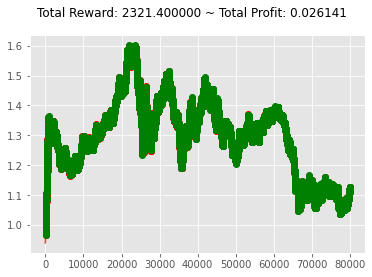

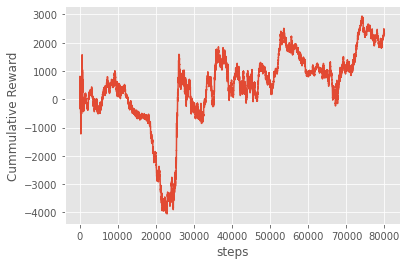

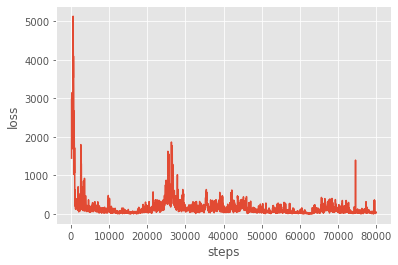

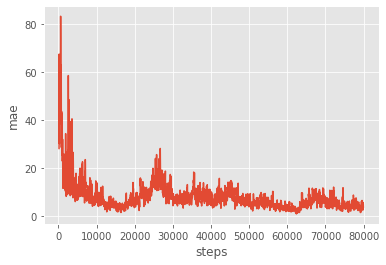

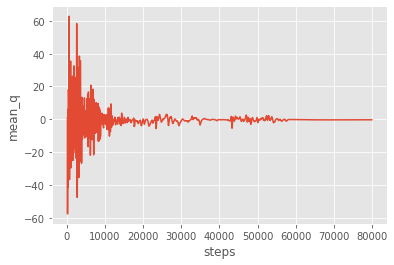

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2306s 144ms/step - reward: -37.8091 - cumulative_reward: -471.2724
train 2 completed. took 4639.790 seconds, total_reward: -145.59999999927484 total_profit: 0.024160027672005747
min reward: -380.00000000000034, max reward: 353.99999999999875, mean_reward: -0.0018211609901221384


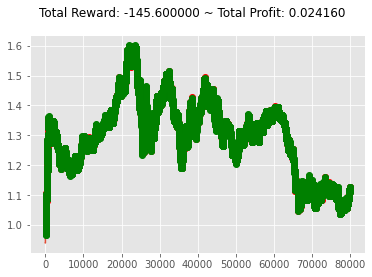

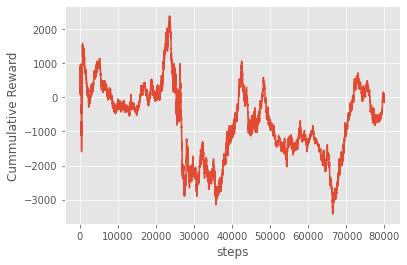

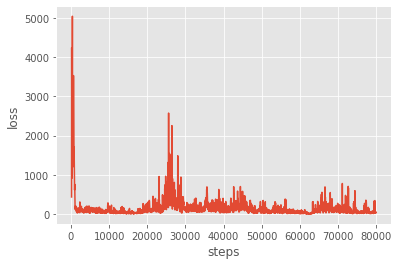

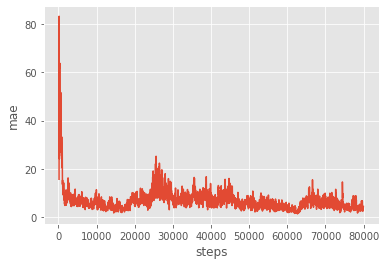

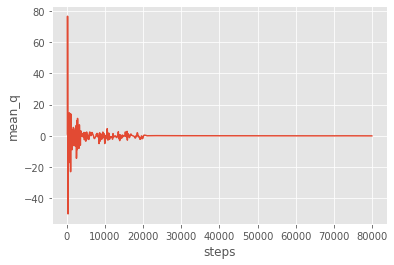

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2363s 148ms/step - reward: -50.9193 - cumulative_reward: 7616.8984
train 3 completed. took 7056.491 seconds, total_reward: 9285.100000000371 total_profit: 0.03382641770061801
min reward: -340.0000000000003, max reward: 430.29999999999905, mean_reward: 0.11613778783975248


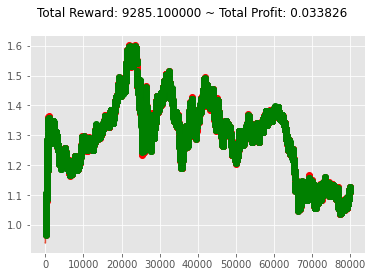

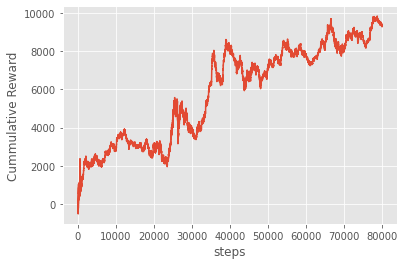

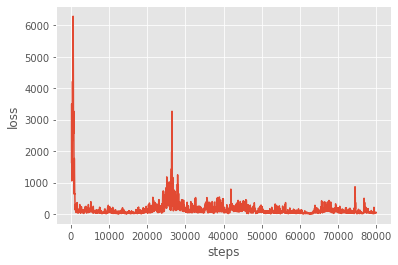

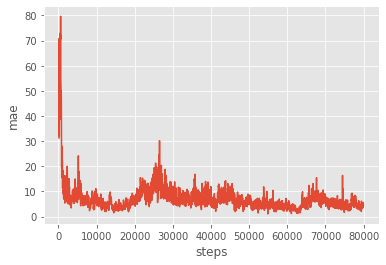

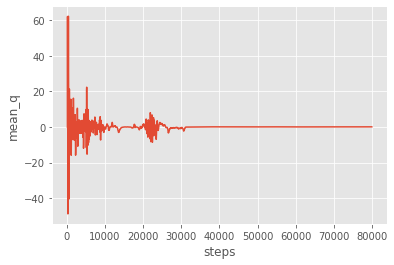

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2287s 143ms/step - reward: 1.0503 - cumulative_reward: -2914.5647
train 4 completed. took 9400.410 seconds, total_reward: -3991.899999999989 total_profit: 0.020295892149308953
min reward: -372.70000000000135, max reward: 379.00000000000045, mean_reward: -0.049930580745224946


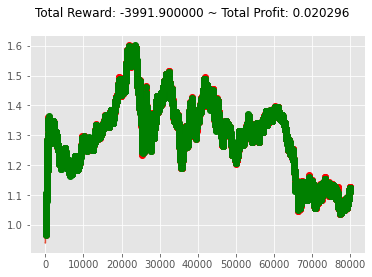

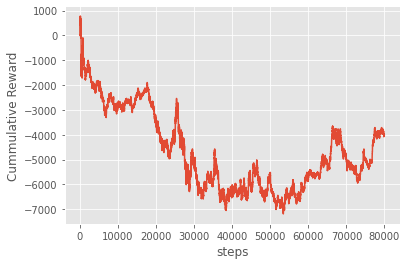

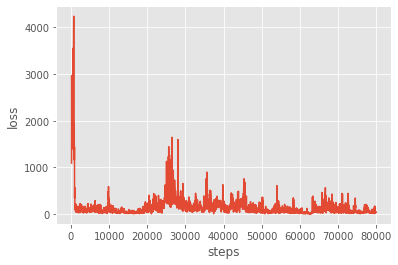

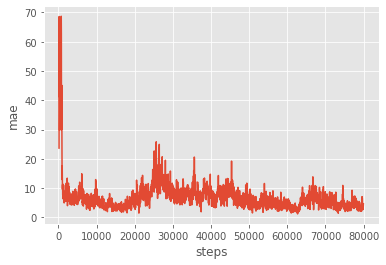

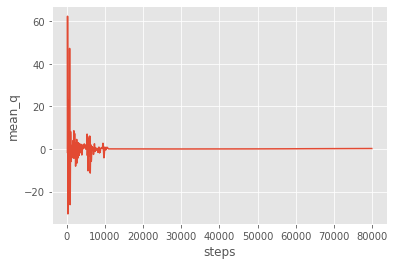

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
15989/15989 [==============================] - 2451s 153ms/step - reward: 39.9896 - cumulative_reward: -1640.1512
train 5 completed. took 11913.392 seconds, total_reward: -1765.8000000002598 total_profit: 0.020458638328965148
min reward: -351.50000000000017, max reward: 466.39999999999793, mean_reward: -0.022086580194877484


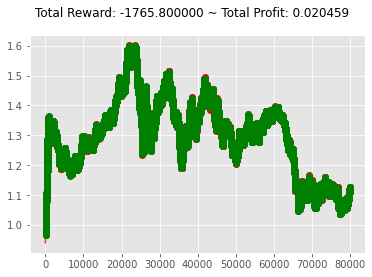

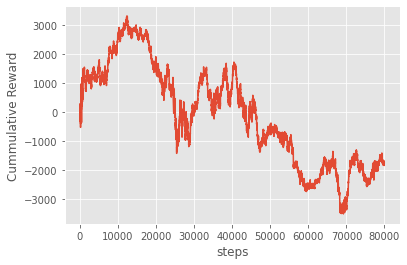

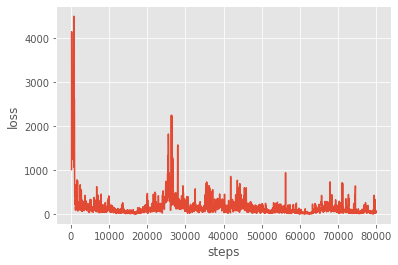

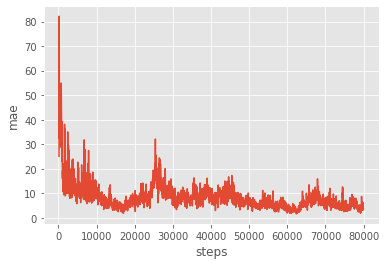

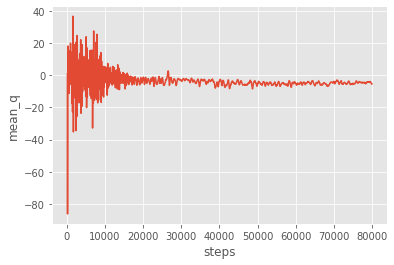

In [10]:
e = Evaluator(agent_creator, env_creator, name="ddpg-90k")
e.train(repeat=5)

average of total_reward across trainings: [1140.64]


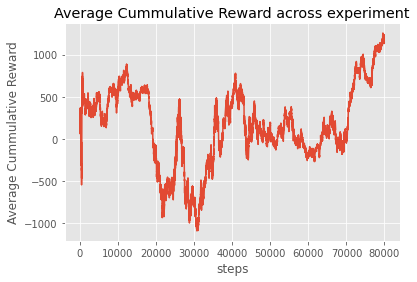

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
1999/1999 [==============================] - 58s 29ms/step - reward: -29.0054 - cumulative_reward: -592.0297
Episode 1: reward: -1410.600, steps: 9999
test completed. total_reward: -1410.6000000000438 total_profit: 0.5544015784216237
min reward: -149.7000000000015, max reward: 220.79999999999876, mean_reward: -0.14107410741074544


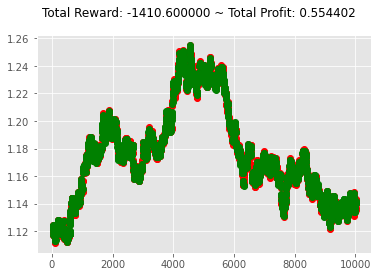

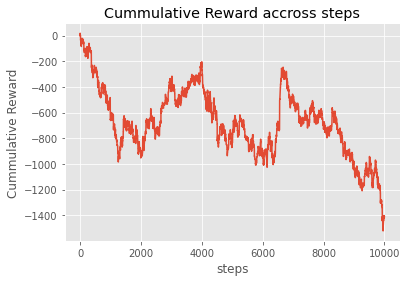

In [11]:
e.process_train_result()
e.test(ExternalDataFullFeature(df=EURUSD_HOUR, window_size=window_size, frame_bound=(80000, 90000)))